In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logging
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.datasets import cifar10

from sklearn.preprocessing import StandardScaler

In [2]:
# This is the configuration for the logging output

logging_format = '%(message)s'
logging.basicConfig(format=logging_format, level=logging.INFO)

# Set the tensorflow logger level to 'FATAL' to avoid tf showing messages
tf.autograph.set_verbosity(0)

# Neural Network for classification on the dataset CIFAR10

This notebook contains the solution for the exercise #8 of the chapter 11: *Training a Neural Network* of the book *Hands On Machine Learning with Scikit-Learn, Keras & TensorFlow* of Aurélien Géron.

## Exercise

#### **Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the ELU activation function. Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with keras.datasets.cifar10.load_ data(). The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you’ll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model’s architecture or hyperparameters.**

First we will obtain the data set and inspect the data. You can visit the [website of the *CIFAR10*](https://www.cs.toronto.edu/~kriz/cifar.html) to look the documentation available. 

In [3]:
# Get the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_valid, x_train = x_train[:5000], x_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

# Explore the data
logging.info(f'The shape of the training data is {x_train.shape} for the inputs and {y_train.shape} for the outputs.')
logging.info(f'\tThe minimum value for the input is {np.min(x_train)}')
logging.info(f'\tThe maximum value is {np.max(x_train)}')
logging.info(f'\tThe standard deviation is {round(np.std(x_train), 2)}')

The shape of the training data is (45000, 32, 32, 3) for the inputs and (45000, 1) for the outputs.
	The minimum value for the input is 0
	The maximum value is 255
	The standard deviation is 64.12


As we can see the data are images of 32 x 32 pixels, with 3 layers of colors (Red, Blue and Green). Let's now see the different outputs we have:

In [4]:
unique_outputs = np.unique(y_train)

logging.info(f'The unique values for the outputs are {unique_outputs}')

The unique values for the outputs are [0 1 2 3 4 5 6 7 8 9]


The different classes are numbers *0-9*. In the official website we can find the classes correspond to:

|Class|Description|
|:---:|:---:|
|0|Airplane|
|1|Automobile|
|2|Bird|
|3|Cat|
|4|Deer|
|5|Dog|
|6|Frog|
|7|Horse|
|8|Ship|
|9|Truck|

Let's visualize 5 random images with their labels.

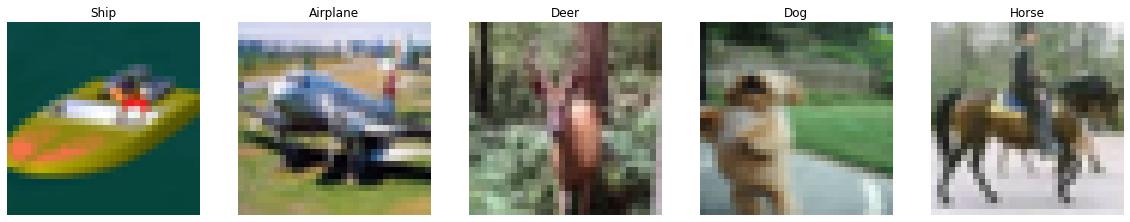

In [5]:
labels_cifar = {
    0 : 'Airplane',
    1 : 'Automobile',
    2 : 'Bird',
    3 : 'Cat',
    4 : 'Deer',
    5 : 'Dog',
    6 : 'Frog',
    7 : 'Horse',
    8 : 'Ship',
    9 : 'Truck'
}

plt.figure(figsize=(20, 10))

for i in range(5):
    random_image = np.random.randint(0, 40000) # Here 40000 is the number of instances for trarining
    plt.subplot(1, 5, i+1)
    plt.imshow(x_train[random_image])
    plt.title(labels_cifar[y_train.reshape(-1)[random_image]])
    plt.axis('off')

Then, we will create the network as requested by the author: a 20 hidden layer network with ```activation='elu'```, using Nadam optimizer and early stopping.

The ELU acitvation stands for *Exponential Linear Unit*, and its equation is:
- ELU $_\alpha (z) = \begin{cases} \alpha(exp(z) - 1) & \text{if }z<0 \\ z & \text{if }z\ge0\end{cases}$
- Where $\alpha$ is a hyperparameter that defines the value the ELU function will approach when $z$ is a large negative number

It has the following plot:.

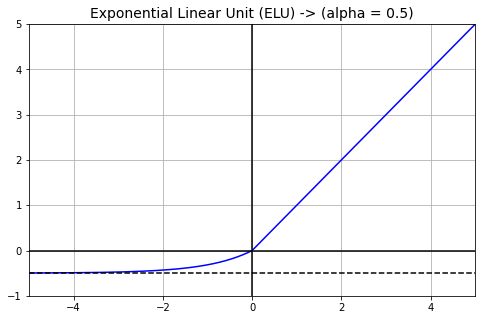

In [6]:
x = np.arange(-5, 5, step=0.01)
alpha_elu = 0.5
elu = np.where(x < 0, alpha_elu * (np.exp(x) - 1), x)

plt.figure(figsize=(8, 5))

plt.plot(x, elu, 'b-')
plt.vlines(0, -2, 6, colors='black')
plt.hlines(-alpha_elu, -5, 5, colors='black', linestyles='dashed')
plt.hlines(0, -5, 5, colors='black')

plt.xlim(-5, 5)
plt.ylim(-1, 5)
plt.grid(True)
plt.title(f'Exponential Linear Unit (ELU) -> (alpha = {alpha_elu})', fontsize=14)

plt.show()

The benefits that *ELU* provides are:

- If $z$ is negative, the output of the neuron will be negative approaching to $\alpha$, avoiding nonzero gradients for $z < 0$, in other words, the derivative for $z < 0$ will no longer be zero. This helps avoiding some neurons dying (output zero) when the sum of the weights of the neuron is negative. This problem is known as *dying ReLU*.

The exercise also requests to have the optimizer *Nadam*. This is an alternative optimizer to the general *Stochastic Gradient Descent*. The algorithm is complex to explain here, however, if you are interested check this [article](https://medium.datadriveninvestor.com/overview-of-different-optimizers-for-neural-networks-e0ed119440c3). In short, this optimizer allows the model to converge faster to an optimal solution by using a different algorith to update the weights of the network.

Let's create the network:

In [7]:
keras.backend.clear_session()
tf.random.set_seed(15)
np.random.seed(15)

model = models.Sequential([
    layers.Flatten(input_shape=[32, 32, 3])
])

# Add the 20 layers with 100 neurons
for _ in range(20):
    model.add(layers.Dense(100,
                           activation='elu',
                           kernel_initializer='he_normal'))

model.add(layers.Dense(10, activation='softmax'))

# Create the optimizer
optimizer_nadam = optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer_nadam,
              metrics=['accuracy'])

# Create the callbacks
early_stopping_cb = callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = callbacks.ModelCheckpoint('models/cifar10_model.h5', save_best_only=True)
callbacks_list = [early_stopping_cb, model_checkpoint_cb]

history_cifar10 = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            epochs=300,
                            batch_size=1500,        # Only if you can use GPU acceleration
                            callbacks=callbacks_list,
                            verbose=2)


2022-01-06 19:59:50.402281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-06 19:59:50.402660: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-01-06 19:59:50.748018: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/300


2022-01-06 19:59:51.694147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-06 19:59:55.592751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 - 5s - loss: 58.4376 - accuracy: 0.1024 - val_loss: 6.1324 - val_accuracy: 0.1023 - 5s/epoch - 175ms/step
Epoch 2/300
30/30 - 3s - loss: 3.7578 - accuracy: 0.1226 - val_loss: 2.3904 - val_accuracy: 0.1705 - 3s/epoch - 86ms/step
Epoch 3/300
30/30 - 3s - loss: 2.2977 - accuracy: 0.1738 - val_loss: 2.2523 - val_accuracy: 0.1799 - 3s/epoch - 86ms/step
Epoch 4/300
30/30 - 3s - loss: 2.2129 - accuracy: 0.1949 - val_loss: 2.1983 - val_accuracy: 0.1914 - 3s/epoch - 85ms/step
Epoch 5/300
30/30 - 3s - loss: 2.1756 - accuracy: 0.2063 - val_loss: 2.1963 - val_accuracy: 0.1870 - 3s/epoch - 85ms/step
Epoch 6/300
30/30 - 3s - loss: 2.1493 - accuracy: 0.2161 - val_loss: 2.1350 - val_accuracy: 0.2274 - 3s/epoch - 85ms/step
Epoch 7/300
30/30 - 3s - loss: 2.1114 - accuracy: 0.2292 - val_loss: 2.0346 - val_accuracy: 0.2508 - 3s/epoch - 86ms/step
Epoch 8/300
30/30 - 2s - loss: 2.0681 - accuracy: 0.2410 - val_loss: 2.0353 - val_accuracy: 0.2592 - 2s/epoch - 83ms/step
Epoch 9/300
30/30 - 3s - loss: 2.0

In [8]:
def model_performance(history_model, model_filepath, x_test, y_test):
    pd.DataFrame(history_model.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 5)
    plt.title('Training of the model')
    plt.show()
    
    model = models.load_model(model_filepath)
    evaluation = model.evaluate(x_test, y_test, verbose=0)
    logging.info(f'The accuracy of the model is {round(evaluation[1], 4) * 100}%')

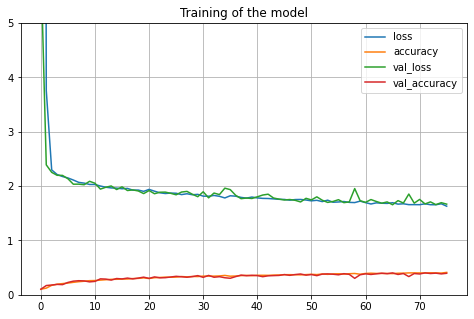

2022-01-06 20:03:07.094150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
The accuracy of the model is 40.29%


In [9]:
model_performance(history_cifar10, 'models/cifar10_model.h5', x_test, y_test)

We can see that the accuracy of the model is low.


#### **Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?**

The *Batch Normalization* is an intermediate layer that normalize the data (zero centering and normalizing the input) before or after the activation function. It is suggested to add the BN before the activation function.

The benefits of adding the BN are that it regularizes the data, and avoid the vanishing/exploding of the gradients when updating the weights in backpropagation.

Let's create a function to evaluate the accuracy with different learning rates:

In [10]:
def evaluate_model(learning_rate):

    # Add a BatchNormalization layer after the input to zero-center and normalize the data
    model = models.Sequential([
        layers.Flatten(input_shape=[32, 32, 3]),
        layers.BatchNormalization()
    ])

    # Add 20 layers without activation. Then, the BatchNormalization layer is added
    # Finally a new layer for the activation is added

    for _ in range(20):
        model.add(layers.Dense(100, kernel_initializer='he_normal'))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation('elu'))

    model.add(layers.Dense(10, activation='softmax'))

    optimizer_nadam = optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer_nadam,
                metrics=['accuracy'])

    # Train the model for only 25 epochs
    model.fit(x_train, y_train,
            validation_data=(x_valid, y_valid),
            epochs=25,
            batch_size=1500,
            verbose=0)

    evaluation = model.evaluate(x_test, y_test, verbose=0)

    logging.info(f'Learning rate: {learning_rate}\nAccuracy: {round(evaluation[1], 4) * 100}%\n')


We can also train the model with different learning rate. In the next step, we will try different learning rates to see wich has a better performance:

In [11]:
keras.backend.clear_session()
tf.random.set_seed(15)
np.random.seed(15)

lr = 1e-4

while lr < 1e-2:
    evaluate_model(lr)
    lr *= 2

2022-01-06 20:03:15.204226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-06 20:03:25.469380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Learning rate: 0.0001
Accuracy: 45.49%

2022-01-06 20:05:18.241343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-06 20:05:29.483396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Learning rate: 0.0002
Accuracy: 46.73%

2022-01-06 20:07:20.133788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-06 20:07:31.992307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is

It seems like the optimal learning rate of 0.0064 is promising. We will try to look for the options between ```6e-4``` and ```1e-3``` with steps of ```1e-4```:

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(15)
np.random.seed(15)

lr = 6e-3

while lr < 1e-2:
    evaluate_model(lr)
    lr += 1e-3

2022-01-04 21:41:32.333586: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 21:41:46.061714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Learning rate: 0.006
Accuracy: 50.24999999999999%

2022-01-04 21:43:37.992110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 21:43:51.581251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
Learning rate: 0.007
Accuracy: 51.080000000000005%

2022-01-04 21:45:43.517258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 21:45:57.563529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer

It appears that the learning rate that works the best is ```8e-3```. Let's train the model with this $\eta$:

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(15)
np.random.seed(15)

lr = 8e-3

model = models.Sequential([
    layers.Flatten(input_shape=[32, 32, 3]),
    layers.BatchNormalization()
])

for _ in range(20):
    model.add(layers.Dense(100, kernel_initializer='he_normal'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))

model.add(layers.Dense(10, activation='softmax'))

optimizer_nadam = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)

model.compile(loss='sparse_categorical_crossentropy',
            optimizer=optimizer_nadam,
            metrics=['accuracy'])

# Create the callbacks
early_stopping_cb = callbacks.EarlyStopping(patience=10)
model_checkpoint_cb = callbacks.ModelCheckpoint('models/cifar10_model_bn.h5')
callbacks_list = [early_stopping_cb, model_checkpoint_cb]

history_bn = model.fit(x_train, y_train,
        validation_data=(x_valid, y_valid),
        epochs=200,
        batch_size=1500,
        callbacks=callbacks_list,
        verbose=2)

model = models.load_model(f'models/cifar10_model_bn.h5')

Epoch 1/200


2022-01-04 21:49:57.744716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 21:50:12.898213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 - 19s - loss: 2.1494 - accuracy: 0.2324 - val_loss: 23.6023 - val_accuracy: 0.1278 - 19s/epoch - 631ms/step
Epoch 2/200
30/30 - 5s - loss: 1.8411 - accuracy: 0.3386 - val_loss: 20.7005 - val_accuracy: 0.1430 - 5s/epoch - 155ms/step
Epoch 3/200
30/30 - 4s - loss: 1.7388 - accuracy: 0.3778 - val_loss: 13.8531 - val_accuracy: 0.1738 - 4s/epoch - 149ms/step
Epoch 4/200
30/30 - 4s - loss: 1.6708 - accuracy: 0.4038 - val_loss: 12.1898 - val_accuracy: 0.1966 - 4s/epoch - 148ms/step
Epoch 5/200
30/30 - 4s - loss: 1.6201 - accuracy: 0.4264 - val_loss: 6.0589 - val_accuracy: 0.3116 - 4s/epoch - 147ms/step
Epoch 6/200
30/30 - 4s - loss: 1.5566 - accuracy: 0.4485 - val_loss: 6.0530 - val_accuracy: 0.3406 - 4s/epoch - 149ms/step
Epoch 7/200
30/30 - 4s - loss: 1.5110 - accuracy: 0.4660 - val_loss: 4.5483 - val_accuracy: 0.3768 - 4s/epoch - 147ms/step
Epoch 8/200
30/30 - 4s - loss: 1.4721 - accuracy: 0.4787 - val_loss: 4.1141 - val_accuracy: 0.3744 - 4s/epoch - 146ms/step
Epoch 9/200
30/30 - 4s

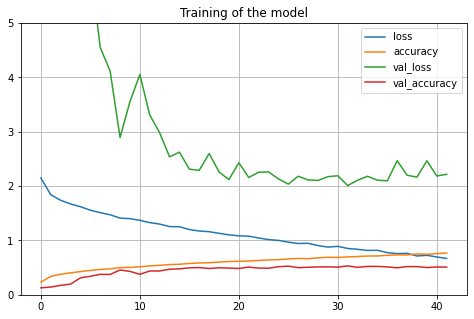

2022-01-04 21:53:14.906889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
The accuracy of the model is 49.78%


In [ ]:
model_performance(history_bn, 'models/cifar10_model_bn.h5', x_test, y_test)

There are some points we need to address at this moment:

- The model has converged in less epochs.
- The model has better accuracy with the ```BatchNormalization``` layer. However, by analizing the loss of the model with training data and with the validation data, we can see the model is overfitting. More regularization may be necessary. Adding Dropout layers may improve the performance of the model. An alternative would be to add ```kernel_regularizer=keras.regularizers.l2()``` to add regularization to the model. 
- We can see the model is slower per epoch, but this is compensated needing less epochs to converge.

#### **Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).**

First let's create a new model. The changes that we have to make relative to the previous model are:

- Standardize the input of the model.
- Remove the ```BatchNormalization``` layers.
- Change the activation function to ```activation='selu'```.
- Use ```kernel_initializer='lecun'``` for the hidden layers.

Let's start by stardardizing the input of the model. In order to standardize, we will use the method ```sklearn.preprocessing.StandardScaler()```. This method calculates the output as follows:

- $Z(x) = (x_i - \mu) / \sigma$

- This gives us data that is zero-centered and has standard deviation of 1.

Note that ```sklearn.preprocessing.StandardScaler()``` takes as input arrays with 2 dimensions. In the case of the CIFAR-10 dataset it will be necessary to reshape twice: The first time to adapt the input array, and the second to return the array to its origin form. 

In [ ]:
logging.info(f'The maximum value for the training set before standardizing is {np.max(x_train)}, and the minimum value is {np.min(x_train)}.')

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train.reshape(-1, 3072)).reshape(-1, 32, 32, 3)
x_valid_scaled = scaler.transform(x_valid.reshape(-1, 3072)).reshape(-1, 32, 32, 3)
x_test_scaled = scaler.transform(x_test.reshape(-1, 3072)).reshape(-1, 32, 32, 3)

logging.info(f'The maximum value of the training set after standardizing is {np.max(x_train_scaled)}, and the minimum value is {np.min(x_train_scaled)}')

The maximum value for the training set before standardizing is 255, and the minimum value is 0.
The maximum value of the training set after standardizing is 2.6190103737959047, and the minimum value is -2.2103585429171897


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(15)
np.random.seed(15) 

# Create the model
selu_model = models.Sequential([
    layers.Flatten(input_shape=[32, 32, 3])
])

for _ in range(20):
    selu_model.add(layers.Dense(100, 
                                activation='selu', 
                                kernel_initializer='lecun_normal'))

selu_model.add(layers.Dense(10,
                            activation='softmax',
                            kernel_initializer='glorot_normal'))

# Optimizer and compilation
optimizer_nadam = optimizers.Nadam(learning_rate=lr, beta_1=0.9, beta_2=0.999)

# Callbacks
model_checkpoint_selu = callbacks.ModelCheckpoint('models/cifar10_model_selu.h5', save_best_only=True)
callbacks_list = [early_stopping_cb, model_checkpoint_selu]

selu_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer_nadam,
                   metrics=['accuracy'])

selu_history = selu_model.fit(x_train_scaled, y_train,
                              validation_data=[x_valid_scaled, y_valid],
                              batch_size=1500,
                              epochs=200,
                              callbacks=callbacks_list,
                              verbose=2)

Epoch 1/200


2022-01-04 21:53:26.757895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-04 21:53:32.409315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


30/30 - 7s - loss: 6.5044 - accuracy: 0.1035 - val_loss: 4.1113 - val_accuracy: 0.1074 - 7s/epoch - 242ms/step
Epoch 2/200
30/30 - 3s - loss: 3.1357 - accuracy: 0.0984 - val_loss: 2.2764 - val_accuracy: 0.1530 - 3s/epoch - 88ms/step
Epoch 3/200
30/30 - 3s - loss: 2.1706 - accuracy: 0.1898 - val_loss: 2.0216 - val_accuracy: 0.2510 - 3s/epoch - 86ms/step
Epoch 4/200
30/30 - 3s - loss: 2.0620 - accuracy: 0.2262 - val_loss: 2.0899 - val_accuracy: 0.2060 - 3s/epoch - 85ms/step
Epoch 5/200
30/30 - 3s - loss: 1.9674 - accuracy: 0.2536 - val_loss: 1.9437 - val_accuracy: 0.2692 - 3s/epoch - 86ms/step
Epoch 6/200
30/30 - 3s - loss: 1.9123 - accuracy: 0.2845 - val_loss: 2.0295 - val_accuracy: 0.2448 - 3s/epoch - 84ms/step
Epoch 7/200
30/30 - 3s - loss: 1.8363 - accuracy: 0.3148 - val_loss: 1.9031 - val_accuracy: 0.3030 - 3s/epoch - 87ms/step
Epoch 8/200
30/30 - 3s - loss: 1.8018 - accuracy: 0.3327 - val_loss: 1.7589 - val_accuracy: 0.3478 - 3s/epoch - 87ms/step
Epoch 9/200
30/30 - 3s - loss: 1.74

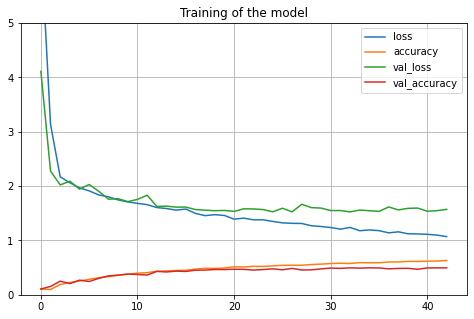

2022-01-04 21:55:21.350679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
The accuracy of the model is 48.980000000000004%


In [ ]:
model_performance(selu_history, 'models/cifar10_model_selu.h5', x_test_scaled, y_test)

#### **Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.**

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(15)
np.random.seed(15)

# Create the model
drop_model = models.Sequential([
    layers.Flatten(input_shape=[32, 32, 3])
])

for _ in range(20):
    drop_model.add(layers.Dense(100, 
                                activation='selu', 
                                kernel_initializer='lecun_normal'))
    drop_model.add(layers.AlphaDropout(rate=0.2))

drop_model.add(layers.Dense(10, activation='softmax', kernel_initializer='glorot_normal'))

# Compile the model

drop_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer=optimizer_nadam,
                   metrics=['accuracy'])

# Train the model
model_checkpoint_drop = callbacks.ModelCheckpoint('models/cifar10_model_drop.h5', save_best_only=True)
callbacks_list = [early_stopping_cb, model_checkpoint_drop]

drop_history = drop_model.fit(x_train_scaled, y_train,
                              validation_data=[x_valid_scaled, y_valid],
                              epochs=200,
                              batch_size=1500,
                              callbacks=callbacks_list,
                              verbose=2)

In [ ]:
model_performance(drop_history, 'models/cifar10_model_drop.h5', x_valid_scaled, y_valid)

In order to implement ```MCDropout``` in our model, lets first create the class that subclasses the ```keras.layers.AlphaDropout``` class.

In [ ]:
Class 

#### **Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.**